# Simple audio compression with Python

The aim of this notebook is to compress audio files by changing their sample rate.

Let's first load the source file that we want to compress. We will start from an mp3 file since it is a very common format for audio files. As a first step, we convert this mp3 file into a wav file.

In [1]:
# Consider running the following line if pydub is not already installed:
# !pip install pydub 

In [2]:
from pydub import AudioSegment

mp3File = "source_file.mp3"
wavFile = "source_file.wav"

# Convert wav to mp3                                                            
audio = AudioSegment.from_mp3(mp3File)
audio.export(wavFile, format="wav")

<_io.BufferedRandom name='source_file.wav'>

We then retrieve the data from the wav file.

In [3]:
# Consider running the following line if soundfile is not already installed:
# !pip install soundfile 

In [4]:
import soundfile as sf

# Retrieve the data from the wav file
data, samplerate = sf.read(wavFile) 

* **data** is a 2D-array (with dimensions 2x$n$, with $n$ an integer), that contains the audio data.  
* **samplerate** is the sample rate, which is the number of samples of the audio we have, per second.

In [5]:
print("Sample rate : {} Hz".format(samplerate))

Sample rate : 48000 Hz


Here, the sample rate is 48kHz, which is a standard sampling rate.

Before we start working with audio data, you may wonder what those data physically represent. In fact, sound corresponds to the variation of air pressure, which is then converted to voltages, in order to process it with computers. Thus those audio data can be seen as air pressure variation, or voltages.

For convenience, let's first decompose and rename the different information we have.

In [6]:
import numpy as np

n = len(data) #the length of the arrays contained in data
Fs = samplerate #the sample rate

# Working with stereo audio, there are two channels in the audio data.
# Let's retrieve each channel seperately:
ch1 = np.array([data[i][0] for i in range(n)]) #channel 1
ch2 = np.array([data[i][1] for i in range(n)]) #channel 2

Both channels ch1 and ch2 contain samples from a continuous-time signal. Those samples are taken with a sample rate $F_s$, meaning that those are values from a continuous-time signal that were taken every $1/F_s$ seconds. Mathematically speaking, if $x(t)$ is the time-continuous signal from which we take samples, and $\tilde{x}[k]$ is the sampled signal (so ch1 here for example), then we have for all $0 \leq k < n$
$$ \tilde{x}[k] = x\left(\dfrac{k}{F_s}\right). $$

We can then perform a Fourier analysis on the first channel to see what the spectrum looks like. According to the Nyquist-Shannon theorem, we only look at frequencies below $F_s/2$.

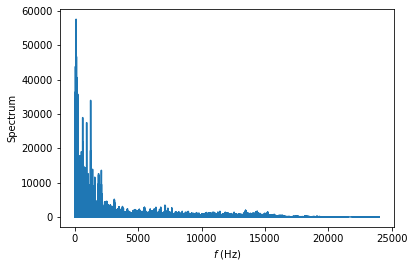

In [7]:
import matplotlib.pyplot as plt

ch1_Fourier = np.fft.fft(ch1) #performing Fast Fourier Transform
abs_ch1_Fourier = np.absolute(ch1_Fourier[:n//2]) #the spectrum

plt.plot(np.linspace(0, Fs / 2, n//2), abs_ch1_Fourier)
plt.ylabel('Spectrum')
plt.xlabel('$f$ (Hz)')
plt.show()

Now, let's define a frequency $f_0$ above which we will cut the spectrum, meaning that we only keep the frequencies below $f_0$ in the compressed audio file. To do that, we introduce a parameter $\varepsilon$ ($0<\varepsilon<1$) that represents the share of the spectrum energy that we do not keep.
<br> Here, we use $\varepsilon=10^{-5}$ to remove only a small portion of the spectrum, but one can change the value of $\varepsilon$ and see how $f_0$ and the output audio file change. Intuitively, as $\varepsilon$ increases, we keep less frequencies so the audio quality is poorer, but the size of the output file is more reduced.

f0 : 23810 Hz


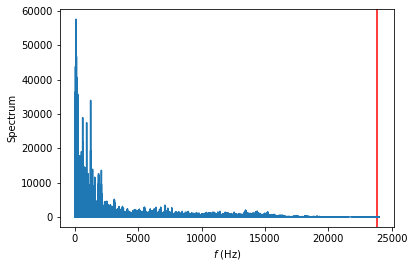

In [10]:
eps = 1e-5

# Boolean array where each value indicates whether we keep the corresponding frequency
frequenciesToRemove = (1 - eps) * np.sum(abs_ch1_Fourier) < np.cumsum(abs_ch1_Fourier)   

# The frequency for which we cut the spectrum
f0 = (len(frequenciesToRemove) - np.sum(frequenciesToRemove) )* (Fs / 2) / (n / 2)

print("f0 : {} Hz".format(int(f0)))

plt.axvline(f0, color='r')
plt.plot(np.linspace(0, Fs / 2, n//2), abs_ch1_Fourier)
plt.ylabel('Spectrum')
plt.xlabel('$f$ (Hz)')
plt.show()

To compress the audio file, we are going to do a simple downsampling here. Downsampling with a factor $D\in\mathbb{N}$ means that we will only keep the sequence $\tilde{x_D}$ defined for all $k$ by
$$\tilde{x_D}[k] = \tilde{x}[D k].$$ 

To find what value of $D$ we should use for downsampling, one way is to compute $D = \left \lfloor \dfrac{F_s}{f_0} \right \rfloor$. This way, the new sample rate will be $F_s / D = \dfrac{F_s}{\left \lfloor \dfrac{F_s}{f_0} \right \rfloor} \gtrsim f_0$. So the frequencies which constitute the main part of the spectrum will remain below the new sample rate.

The code below implements the downsampling of the audio file.

In [9]:
#First we define the names of the output files

wavCompressedFile = "audio_compressed.wav"
mp3CompressedFile = "audio_compressed.mp3"

#Then we define the downsampling factor
D = int(Fs / f0)
print("Downsampling factor : {}".format(D))
new_data = data[::D, :] #getting the downsampled data

#Writing the new data into a wav file
sf.write(wavCompressedFile, new_data, int(Fs / D), 'PCM_16')

#Converting back to mp3

audioCompressed = AudioSegment.from_wav(wavCompressedFile)
audioCompressed.export(mp3CompressedFile, format="mp3")

Downsampling factor : 2


<_io.BufferedRandom name='audio_compressed.mp3'>

When downsampling, there is usually loss and distortion, so the audio quality deteriorates. Therefore, there is a **trade-off between audio quality and storage**.

There are several reasons why the audio quality deteriorates:
* as a consequence of Nyquist-Shannon sampling theorem, there may be aliasing.
* frequencies above half the sample rate are not in the spectrum of the compressed audio anymore.

Some techniques can be further used to perform a better audio compression, for example resorting to anti-aliasing filters, but this is not the topic of this notebook.